# CPC251_Assignment1_GroupNo.Climate3

#### Group Information

Group No: Climate3

- Member 1: Edwin Chia Yi Yang
- Member 2: Hong JingLong
- Member 3: Hong Soon Chuan Jarren
- Member 4: Tan Wei Yi

#### Setup the Python environment and install necessary packages


In [1]:
# python -m venv my_venv
# .\my_venv\Scripts\activate
# pip install tensorflow
# pip install ipykernel
# python -m ipykernel --user --name ML-Kernel
# pip install matplotlib

#### Import Libraries

In [2]:
%config Completer.use_jedi=False

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

#### Load the dataset

In [3]:
dataset = pd.read_csv('classification_dataset.csv')
features = dataset[['f1', 'f2', 'f3', 'f4', 'f5']].values
target = dataset['label'].values

#### Define the loss function

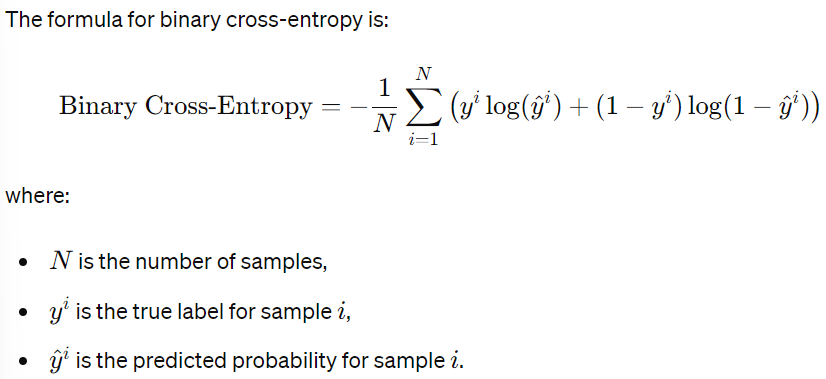

In [4]:
def loss_fn(y_true, y_pred):
    """
    This function calculates the loss function using cross-entropy.

    Parameters:
    y_true (tensor): True labels, a tensor of shape (N,) where each entry is 0 or 1.
    y_pred (tensor): Predictions, a tensor of shape (N,) where each entry is a probability between 0 and 1.

    Returns:
    tensor: The mean binary cross-entropy loss.
    """
    
    # Convert both tensors to float32
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    # Convert y_pred to a small range to avoid log(0) error
    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    # Calculate the binary cross-entropy loss
    loss = -tf.reduce_mean(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

    return loss

In [5]:
"""
    A loss function that will provide more accurate confusion matrix
"""
#  def loss_fn(labels, predictions):
# #    This function calculates the loss function using cross-entropy.
    
#     labels_expanded = tf.expand_dims(tf.cast(labels, dtype=tf.float32), -1)  # Expand dimensions to match logits
#     return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=predictions, labels=labels_expanded))

'\n    A loss function that will provide more accurate confusion matrix\n'

#### Define function to perform prediction

In [6]:
def sigmoid(x):
    """ 
    This function calculates the sigmoid function.
    """
    return 1 / (1 + tf.exp(-x))

def relu(x):
    """ 
    This function calculates the ReLU function.
    """
    return tf.maximum(x, 0)

def forward(X, W1, b1, W2, b2):
    """ 
    This function calculates the forward pass (predicts the label).
    """
    Z1 = tf.add(tf.matmul(X, W1), b1)
    A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(A1, W2), b2)
    A2 = sigmoid(Z2)
    return A2

#### Define function for model training
Display the training and validation loss values for each epoch of the training loop. The displayed value must be in 6 decimal places.<br>
Hint: <br>
Use `tf.GradientTape` to compute the gradients.

In [7]:
def train(X_batch, y_batch, model_params, learning_rate=0.01):
    """
    This function performs the forward pass, computes the gradient, and updates the weights and biases.
    """
    with tf.GradientTape() as tape:
        predictions = forward(tf.convert_to_tensor(X_batch, dtype=tf.float32), *model_params)
        loss = loss_fn(tf.convert_to_tensor(y_batch, dtype=tf.float32), predictions)
    gradients = tape.gradient(loss, model_params)
    for i, param in enumerate(model_params):
        param.assign_sub(learning_rate * gradients[i])
    return loss.numpy()


def fit(X_train, y_train, X_val, y_val, model_params, epochs=2000, batch_size=32, learning_rate=0.01, patience=10):
    """
    This function implements the training loop.
    """
    
    training_losses = []  # List to store training losses
    validation_losses = []  # List to store validation losses
    best_val_loss = float('inf')  # Initialize the best validation loss to infinity
    wait = 0  # Counter for patience

    for epoch in range(epochs):
        # Mini-batch training
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            train_loss = train(X_batch, y_batch, model_params, learning_rate)

        # Calculate training loss for the last batch
        training_losses.append(train_loss)

        # Validation loss
        val_predictions = forward(tf.convert_to_tensor(X_val, dtype=tf.float32), *model_params)
        val_loss = loss_fn(tf.convert_to_tensor(y_val, dtype=tf.int32), val_predictions).numpy()
        validation_losses.append(val_loss)

        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0  # Reset wait counter
        else:
            wait += 1  # Increment the wait counter
        
        # Early stopping condition
        if wait >= patience:
            print(f"Stopping early at epoch {epoch+1}")
            break
        
        print(f"Epoch {epoch+1}, Training Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}")
    
    return training_losses, validation_losses

#### Define the tensors to hold the weights and biases (create the model)
Hint: <br>
Use `tf.Variable` to create the tensors.<br>
Put the tensors in a list.

In [8]:
num_features = 5
num_hidden_units = 10  # Size of the hidden layer
num_outputs = 1  # Assuming binary classification

W1 = tf.Variable(tf.random.normal(shape=(num_features, num_hidden_units), stddev=np.sqrt(2.0/num_features)))
b1 = tf.Variable(tf.zeros(shape=(num_hidden_units,)))
W2 = tf.Variable(tf.random.normal(shape=(num_hidden_units, num_outputs), stddev=np.sqrt(2.0/num_hidden_units)))
b2 = tf.Variable(tf.zeros(shape=(num_outputs,)))

model_parameters = [W1, b1, W2, b2]

#### Split the dataset
The ratio of training and test is 7:1:2.

In [9]:
# Split the dataset into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)  # 0.125 * 0.8 = 0.1

#### Normalize the data

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#### Train the model

In [11]:
training_losses, validation_losses = fit(X_train, y_train, X_val, y_val, model_parameters)

Epoch 1, Training Loss: 0.757264, Validation Loss: 0.782539
Epoch 2, Training Loss: 0.746356, Validation Loss: 0.769643
Epoch 3, Training Loss: 0.737586, Validation Loss: 0.759135
Epoch 4, Training Loss: 0.730520, Validation Loss: 0.750515
Epoch 5, Training Loss: 0.724799, Validation Loss: 0.743381
Epoch 6, Training Loss: 0.720145, Validation Loss: 0.737444
Epoch 7, Training Loss: 0.716348, Validation Loss: 0.732479
Epoch 8, Training Loss: 0.713217, Validation Loss: 0.728284
Epoch 9, Training Loss: 0.710625, Validation Loss: 0.724732
Epoch 10, Training Loss: 0.708468, Validation Loss: 0.721711
Epoch 11, Training Loss: 0.706664, Validation Loss: 0.719146
Epoch 12, Training Loss: 0.705122, Validation Loss: 0.716947
Epoch 13, Training Loss: 0.703818, Validation Loss: 0.715054
Epoch 14, Training Loss: 0.702715, Validation Loss: 0.713409
Epoch 15, Training Loss: 0.701775, Validation Loss: 0.711954
Epoch 16, Training Loss: 0.700975, Validation Loss: 0.710687
Epoch 17, Training Loss: 0.700290

Epoch 136, Training Loss: 0.693514, Validation Loss: 0.696388
Epoch 137, Training Loss: 0.693504, Validation Loss: 0.696367
Epoch 138, Training Loss: 0.693495, Validation Loss: 0.696346
Epoch 139, Training Loss: 0.693486, Validation Loss: 0.696325
Epoch 140, Training Loss: 0.693476, Validation Loss: 0.696305
Epoch 141, Training Loss: 0.693467, Validation Loss: 0.696284
Epoch 142, Training Loss: 0.693458, Validation Loss: 0.696264
Epoch 143, Training Loss: 0.693449, Validation Loss: 0.696244
Epoch 144, Training Loss: 0.693441, Validation Loss: 0.696225
Epoch 145, Training Loss: 0.693432, Validation Loss: 0.696205
Epoch 146, Training Loss: 0.693423, Validation Loss: 0.696186
Epoch 147, Training Loss: 0.693415, Validation Loss: 0.696167
Epoch 148, Training Loss: 0.693406, Validation Loss: 0.696148
Epoch 149, Training Loss: 0.693398, Validation Loss: 0.696130
Epoch 150, Training Loss: 0.693389, Validation Loss: 0.696111
Epoch 151, Training Loss: 0.693381, Validation Loss: 0.696093
Epoch 15

Epoch 269, Training Loss: 0.692790, Validation Loss: 0.694833
Epoch 270, Training Loss: 0.692787, Validation Loss: 0.694827
Epoch 271, Training Loss: 0.692784, Validation Loss: 0.694821
Epoch 272, Training Loss: 0.692782, Validation Loss: 0.694815
Epoch 273, Training Loss: 0.692778, Validation Loss: 0.694810
Epoch 274, Training Loss: 0.692776, Validation Loss: 0.694804
Epoch 275, Training Loss: 0.692773, Validation Loss: 0.694798
Epoch 276, Training Loss: 0.692770, Validation Loss: 0.694793
Epoch 277, Training Loss: 0.692768, Validation Loss: 0.694787
Epoch 278, Training Loss: 0.692766, Validation Loss: 0.694782
Epoch 279, Training Loss: 0.692763, Validation Loss: 0.694776
Epoch 280, Training Loss: 0.692760, Validation Loss: 0.694771
Epoch 281, Training Loss: 0.692758, Validation Loss: 0.694765
Epoch 282, Training Loss: 0.692755, Validation Loss: 0.694760
Epoch 283, Training Loss: 0.692753, Validation Loss: 0.694755
Epoch 284, Training Loss: 0.692751, Validation Loss: 0.694749
Epoch 28

Epoch 402, Training Loss: 0.692552, Validation Loss: 0.694357
Epoch 403, Training Loss: 0.692551, Validation Loss: 0.694354
Epoch 404, Training Loss: 0.692550, Validation Loss: 0.694352
Epoch 405, Training Loss: 0.692548, Validation Loss: 0.694350
Epoch 406, Training Loss: 0.692547, Validation Loss: 0.694348
Epoch 407, Training Loss: 0.692546, Validation Loss: 0.694346
Epoch 408, Training Loss: 0.692545, Validation Loss: 0.694344
Epoch 409, Training Loss: 0.692544, Validation Loss: 0.694341
Epoch 410, Training Loss: 0.692543, Validation Loss: 0.694340
Epoch 411, Training Loss: 0.692542, Validation Loss: 0.694337
Epoch 412, Training Loss: 0.692541, Validation Loss: 0.694335
Epoch 413, Training Loss: 0.692540, Validation Loss: 0.694333
Epoch 414, Training Loss: 0.692539, Validation Loss: 0.694331
Epoch 415, Training Loss: 0.692538, Validation Loss: 0.694329
Epoch 416, Training Loss: 0.692537, Validation Loss: 0.694327
Epoch 417, Training Loss: 0.692536, Validation Loss: 0.694325
Epoch 41

Epoch 536, Training Loss: 0.692437, Validation Loss: 0.694161
Epoch 537, Training Loss: 0.692436, Validation Loss: 0.694160
Epoch 538, Training Loss: 0.692434, Validation Loss: 0.694159
Epoch 539, Training Loss: 0.692433, Validation Loss: 0.694158
Epoch 540, Training Loss: 0.692433, Validation Loss: 0.694158
Epoch 541, Training Loss: 0.692432, Validation Loss: 0.694157
Epoch 542, Training Loss: 0.692431, Validation Loss: 0.694156
Epoch 543, Training Loss: 0.692430, Validation Loss: 0.694155
Epoch 544, Training Loss: 0.692429, Validation Loss: 0.694154
Epoch 545, Training Loss: 0.692428, Validation Loss: 0.694153
Epoch 546, Training Loss: 0.692427, Validation Loss: 0.694153
Epoch 547, Training Loss: 0.692426, Validation Loss: 0.694152
Epoch 548, Training Loss: 0.692425, Validation Loss: 0.694151
Epoch 549, Training Loss: 0.692424, Validation Loss: 0.694150
Epoch 550, Training Loss: 0.692423, Validation Loss: 0.694149
Epoch 551, Training Loss: 0.692422, Validation Loss: 0.694148
Epoch 55

Epoch 669, Training Loss: 0.692347, Validation Loss: 0.694066
Epoch 670, Training Loss: 0.692346, Validation Loss: 0.694066
Epoch 671, Training Loss: 0.692345, Validation Loss: 0.694065
Epoch 672, Training Loss: 0.692344, Validation Loss: 0.694064
Epoch 673, Training Loss: 0.692344, Validation Loss: 0.694063
Epoch 674, Training Loss: 0.692343, Validation Loss: 0.694063
Epoch 675, Training Loss: 0.692343, Validation Loss: 0.694062
Epoch 676, Training Loss: 0.692342, Validation Loss: 0.694061
Epoch 677, Training Loss: 0.692341, Validation Loss: 0.694061
Epoch 678, Training Loss: 0.692341, Validation Loss: 0.694060
Epoch 679, Training Loss: 0.692340, Validation Loss: 0.694059
Epoch 680, Training Loss: 0.692340, Validation Loss: 0.694059
Epoch 681, Training Loss: 0.692339, Validation Loss: 0.694058
Epoch 682, Training Loss: 0.692339, Validation Loss: 0.694057
Epoch 683, Training Loss: 0.692338, Validation Loss: 0.694057
Epoch 684, Training Loss: 0.692338, Validation Loss: 0.694056
Epoch 68

Epoch 802, Training Loss: 0.692300, Validation Loss: 0.694004
Epoch 803, Training Loss: 0.692299, Validation Loss: 0.694004
Epoch 804, Training Loss: 0.692299, Validation Loss: 0.694004
Epoch 805, Training Loss: 0.692299, Validation Loss: 0.694003
Epoch 806, Training Loss: 0.692299, Validation Loss: 0.694003
Epoch 807, Training Loss: 0.692299, Validation Loss: 0.694003
Epoch 808, Training Loss: 0.692299, Validation Loss: 0.694003
Epoch 809, Training Loss: 0.692299, Validation Loss: 0.694002
Epoch 810, Training Loss: 0.692299, Validation Loss: 0.694002
Epoch 811, Training Loss: 0.692299, Validation Loss: 0.694001
Epoch 812, Training Loss: 0.692298, Validation Loss: 0.694001
Epoch 813, Training Loss: 0.692298, Validation Loss: 0.694001
Epoch 814, Training Loss: 0.692298, Validation Loss: 0.694000
Epoch 815, Training Loss: 0.692297, Validation Loss: 0.694000
Epoch 816, Training Loss: 0.692297, Validation Loss: 0.694000
Epoch 817, Training Loss: 0.692297, Validation Loss: 0.693999
Epoch 81

Epoch 935, Training Loss: 0.692272, Validation Loss: 0.693963
Epoch 936, Training Loss: 0.692272, Validation Loss: 0.693962
Epoch 937, Training Loss: 0.692272, Validation Loss: 0.693962
Epoch 938, Training Loss: 0.692271, Validation Loss: 0.693962
Epoch 939, Training Loss: 0.692271, Validation Loss: 0.693962
Epoch 940, Training Loss: 0.692271, Validation Loss: 0.693961
Epoch 941, Training Loss: 0.692271, Validation Loss: 0.693961
Epoch 942, Training Loss: 0.692271, Validation Loss: 0.693961
Epoch 943, Training Loss: 0.692271, Validation Loss: 0.693961
Epoch 944, Training Loss: 0.692271, Validation Loss: 0.693960
Epoch 945, Training Loss: 0.692271, Validation Loss: 0.693960
Epoch 946, Training Loss: 0.692270, Validation Loss: 0.693960
Epoch 947, Training Loss: 0.692270, Validation Loss: 0.693959
Epoch 948, Training Loss: 0.692270, Validation Loss: 0.693959
Epoch 949, Training Loss: 0.692270, Validation Loss: 0.693959
Epoch 950, Training Loss: 0.692270, Validation Loss: 0.693959
Epoch 95

Epoch 1067, Training Loss: 0.692253, Validation Loss: 0.693938
Epoch 1068, Training Loss: 0.692252, Validation Loss: 0.693938
Epoch 1069, Training Loss: 0.692252, Validation Loss: 0.693938
Epoch 1070, Training Loss: 0.692252, Validation Loss: 0.693937
Epoch 1071, Training Loss: 0.692252, Validation Loss: 0.693937
Epoch 1072, Training Loss: 0.692251, Validation Loss: 0.693937
Epoch 1073, Training Loss: 0.692251, Validation Loss: 0.693937
Epoch 1074, Training Loss: 0.692250, Validation Loss: 0.693937
Epoch 1075, Training Loss: 0.692249, Validation Loss: 0.693937
Epoch 1076, Training Loss: 0.692249, Validation Loss: 0.693937
Epoch 1077, Training Loss: 0.692248, Validation Loss: 0.693937
Epoch 1078, Training Loss: 0.692248, Validation Loss: 0.693937
Epoch 1079, Training Loss: 0.692247, Validation Loss: 0.693937
Epoch 1080, Training Loss: 0.692247, Validation Loss: 0.693937
Epoch 1081, Training Loss: 0.692246, Validation Loss: 0.693937
Epoch 1082, Training Loss: 0.692245, Validation Loss: 0

Epoch 1198, Training Loss: 0.692191, Validation Loss: 0.693929
Epoch 1199, Training Loss: 0.692191, Validation Loss: 0.693928
Epoch 1200, Training Loss: 0.692190, Validation Loss: 0.693928
Epoch 1201, Training Loss: 0.692190, Validation Loss: 0.693928
Epoch 1202, Training Loss: 0.692190, Validation Loss: 0.693928
Epoch 1203, Training Loss: 0.692190, Validation Loss: 0.693928
Epoch 1204, Training Loss: 0.692190, Validation Loss: 0.693928
Epoch 1205, Training Loss: 0.692189, Validation Loss: 0.693928
Epoch 1206, Training Loss: 0.692189, Validation Loss: 0.693928
Epoch 1207, Training Loss: 0.692189, Validation Loss: 0.693928
Epoch 1208, Training Loss: 0.692189, Validation Loss: 0.693928
Epoch 1209, Training Loss: 0.692189, Validation Loss: 0.693927
Epoch 1210, Training Loss: 0.692189, Validation Loss: 0.693928
Epoch 1211, Training Loss: 0.692188, Validation Loss: 0.693927
Epoch 1212, Training Loss: 0.692188, Validation Loss: 0.693927
Epoch 1213, Training Loss: 0.692187, Validation Loss: 0

Epoch 1330, Training Loss: 0.692193, Validation Loss: 0.693909
Epoch 1331, Training Loss: 0.692193, Validation Loss: 0.693909
Epoch 1332, Training Loss: 0.692193, Validation Loss: 0.693909
Epoch 1333, Training Loss: 0.692193, Validation Loss: 0.693909
Epoch 1334, Training Loss: 0.692193, Validation Loss: 0.693909
Epoch 1335, Training Loss: 0.692193, Validation Loss: 0.693908
Epoch 1336, Training Loss: 0.692193, Validation Loss: 0.693909
Epoch 1337, Training Loss: 0.692194, Validation Loss: 0.693908
Epoch 1338, Training Loss: 0.692194, Validation Loss: 0.693908
Epoch 1339, Training Loss: 0.692194, Validation Loss: 0.693908
Epoch 1340, Training Loss: 0.692194, Validation Loss: 0.693908
Epoch 1341, Training Loss: 0.692194, Validation Loss: 0.693908
Epoch 1342, Training Loss: 0.692194, Validation Loss: 0.693908
Epoch 1343, Training Loss: 0.692195, Validation Loss: 0.693908
Epoch 1344, Training Loss: 0.692195, Validation Loss: 0.693908
Epoch 1345, Training Loss: 0.692195, Validation Loss: 0

Epoch 1461, Training Loss: 0.692203, Validation Loss: 0.693896
Epoch 1462, Training Loss: 0.692204, Validation Loss: 0.693896
Epoch 1463, Training Loss: 0.692204, Validation Loss: 0.693896
Epoch 1464, Training Loss: 0.692204, Validation Loss: 0.693896
Epoch 1465, Training Loss: 0.692204, Validation Loss: 0.693896
Epoch 1466, Training Loss: 0.692204, Validation Loss: 0.693896
Epoch 1467, Training Loss: 0.692204, Validation Loss: 0.693896
Epoch 1468, Training Loss: 0.692204, Validation Loss: 0.693896
Epoch 1469, Training Loss: 0.692204, Validation Loss: 0.693896
Epoch 1470, Training Loss: 0.692204, Validation Loss: 0.693896
Epoch 1471, Training Loss: 0.692204, Validation Loss: 0.693895
Epoch 1472, Training Loss: 0.692205, Validation Loss: 0.693896
Epoch 1473, Training Loss: 0.692205, Validation Loss: 0.693896
Epoch 1474, Training Loss: 0.692205, Validation Loss: 0.693896
Epoch 1475, Training Loss: 0.692205, Validation Loss: 0.693896
Epoch 1476, Training Loss: 0.692205, Validation Loss: 0

#### Display the training loss and validation loss against epoch graph

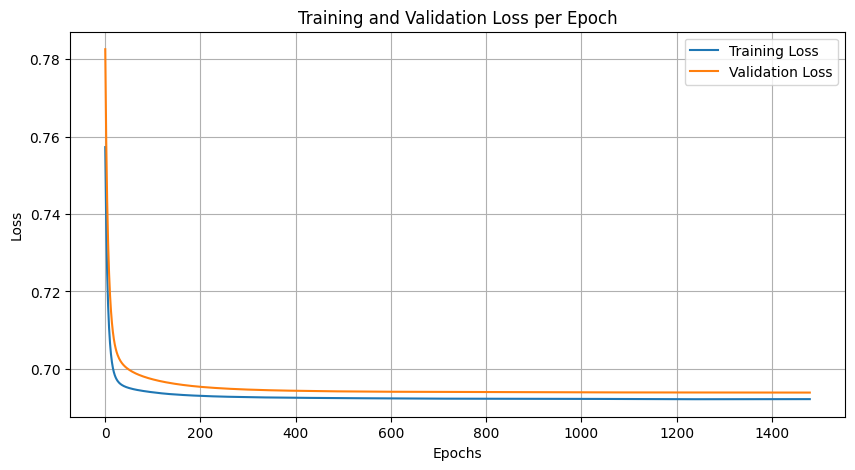

In [12]:
# After training, plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Predict the test set

In [13]:
test_predictions = forward(tf.convert_to_tensor(X_test, dtype=tf.float32), *model_parameters)
test_predicted_labels = tf.cast(tf.greater(test_predictions, 0.5), tf.int32).numpy()

#### Display the confusion matrix and the classification report.

In [14]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predicted_labels))

print("\nClassification Report:")
print(classification_report(y_test, test_predicted_labels, zero_division=0))

Confusion Matrix:
[[63 37]
 [20 80]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.63      0.69       100
           1       0.68      0.80      0.74       100

    accuracy                           0.71       200
   macro avg       0.72      0.72      0.71       200
weighted avg       0.72      0.71      0.71       200

